<a href="https://colab.research.google.com/github/fan-of-dark/UNET_Segmentation/blob/main/Brain_Tumor_Segmentation_with_pre1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)

Mounted at /content/drive/


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("dark_background")
from skimage.io import imread, imshow
from skimage.transform import resize
from glob import glob

import os
import shutil
from tqdm import tqdm

import cv2 as cv
import imutils

In [3]:
data_path = "/content/drive/MyDrive/ECE_MINI_PROJECT/Brain_Tumor/data/"
img_path = "/content/drive/MyDrive/ECE_MINI_PROJECT/Brain_Tumor/data/imgs/"
mask_path = "/content/drive/MyDrive/ECE_MINI_PROJECT/Brain_Tumor/data/masks/"

In [4]:
imgs = next(os.walk(img_path))[2]
masks = next(os.walk(mask_path))[2]

In [5]:
len(imgs), len(masks)

(3929, 3929)

In [8]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

seed = 42
import random
random.seed = seed
np.random.seed = seed

In [23]:
X_train_ = []
Y_train_ = []

In [11]:
def to_gray(img1):
  red = img1[:,:,0]
  green = img1[:,:,1]
  blue = img1[:,:,2]

  #gray level enhancement
  gray = 0.3*red + 0.59*green + 0.11*blue
  gray = gray.astype(np.uint8)
  return gray



def preprocess(img):
  gray = to_gray(img)
  return gray

In [ ]:
X_train_ = []
for img in tqdm(glob(img_path + "*.tif")):
  #IMAGE
  image = imread(img)[:,:,:IMG_CHANNELS]
  #Resizing
  image_ = resize(image, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                  mode = "constant", preserve_range= True)
  #preprocessing
  img_ = preprocess(image_)
  #adding to X_train
  X_train_.append(img_)

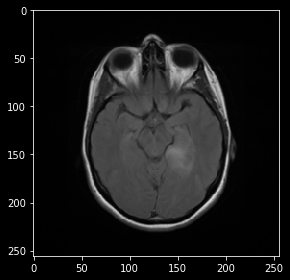

In [44]:
arr = []
img = imread(img_path + imgs[1000])
img_ = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                  mode = "constant", preserve_range= True)
a = preprocess(img)
arr.append(a)
A = np.array(arr, dtype = np.uint8)
imshow(A[0])

In [ ]:
for m in tqdm(glob(mask_path + "*.tif")):
  #MASK
  mask = imread(m)
  #Resizing
  mask_ = np.expand_dims(a = resize(mask, (IMG_HEIGHT, IMG_WIDTH), 
                                    mode = "constant", preserve_range= True),
                        axis = -1)
  #adding to Y_train
  Y_train_.append(mask_)

In [16]:
X_train = np.array(X_train_, dtype = np.uint8)
Y_train = np.array(Y_train_, dtype= np.bool)

In [17]:
X_train.shape

(223, 256, 256, 3)

In [18]:
Y_train.shape

(222, 256, 256, 1)

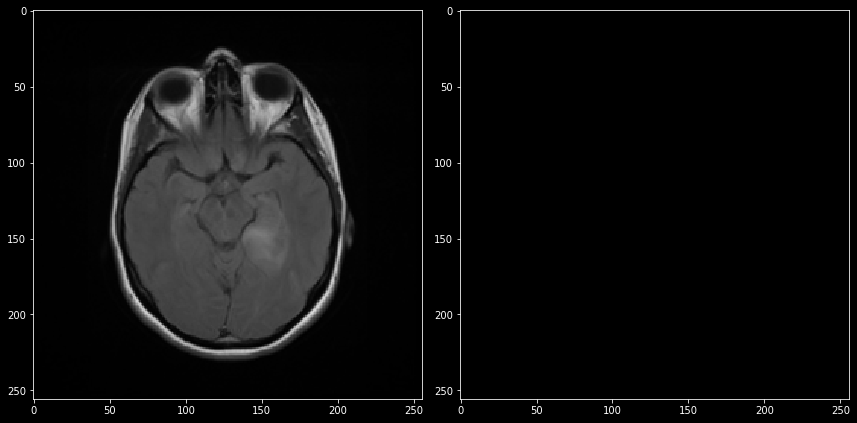

In [45]:
#checking inputs
ind = random.randint(0,len(X_train))
fig = plt.figure(figsize= (12,8))

plt.subplot(1,2,1)
imshow(A[0])
plt.subplot(1,2,2)
imshow(np.squeeze(Y_train[ind]))
plt.show()

They Seems Fine!

In [ ]:
from keras.models import Model, Sequential,load_model
from keras.layers import Conv2D, MaxPool2D, Conv2DTranspose
from keras.layers import Dropout, Lambda
from keras.layers.merge import concatenate
from keras.layers import Input, BatchNormalization, Activation
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras import backend as K
import tensorflow as tf

In [ ]:
def DoubleConv(inp, filters, dropout):
  # A 3X3 2D conv-dropout-conv trio
  layer1 = Conv2D(filters = filters, kernel_size = (3,3), activation= "elu", kernel_initializer= "he_normal", padding = "same")(inp)
  layer2 = Dropout(rate = dropout)(layer1)
  out = Conv2D(filters= filters, kernel_size= (3,3), activation= "elu", kernel_initializer= "he_normal", padding = "same")(layer2)
  return out

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x /255)(inputs)

#ENCODER
c1 = DoubleConv(s, 32, 0.1)

p1 = MaxPool2D((2,2))(c1)

c2 = DoubleConv(p1, 64, 0.1)
p2 = MaxPool2D((2,2))(c2)

c3 = DoubleConv(p2, 128, 0.1)
p3 = MaxPool2D((2,2))(c3)

c4 = DoubleConv(p3, 256, 0.1)
p4 = MaxPool2D((2,2))(c4)

c5 = DoubleConv(p4, 512, 0.1)

#DECODER
u6 = Conv2DTranspose(256, (2,2), strides = (2,2), padding = "same")(c5)
u6 = concatenate([u6, c4])
c6 = DoubleConv(u6, 256, 0.2)

u7 = Conv2DTranspose(128, (2,2), strides = (2,2), padding = "same")(c6)
u7 = concatenate([u7, c3])
c7 = DoubleConv(u7, 128, 0.2)

u8 = Conv2DTranspose(64, (2,2), strides = (2,2), padding = "same")(c7)
u8 = concatenate([u8, c2])
c8 = DoubleConv(u8, 64, 0.1)

u9 = Conv2DTranspose(32, (2,2), strides = (2,2), padding = "same")(c8)
u9 = concatenate([u9, c1])
c9 = DoubleConv(u9, 32, 0.1)

#final layer
outputs = Conv2D(1, (1,1), activation= "sigmoid")(c9)

#model
model = Model(inputs = [inputs], outputs = [outputs])

In [ ]:
model.compile(optimizer = Adam(), loss='binary_crossentropy', metrics=[MeanIoU(num_classes= 2)])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 32) 896         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 32) 0           conv2d_19[0][0]                  
____________________________________________________________________________________________

In [ ]:
early_stopper = EarlyStopping(patience= 5, verbose = 1)
checkpointer = ModelCheckpoint("brain-model-1_1.h5", save_best_only= True)
history = model.fit(X_train, Y_train, validation_split = 0.2, batch_size = 24, epochs = 5, callbacks= [early_stopper,checkpointer])

Epoch 1/5
131/131 [==============================] - 84s 616ms/step - loss: 0.2007 - mean_io_u_1: 0.4947 - val_loss: 0.0453 - val_mean_io_u_1: 0.4940
Epoch 2/5
131/131 [==============================] - 79s 603ms/step - loss: 0.0451 - mean_io_u_1: 0.4945 - val_loss: 0.0423 - val_mean_io_u_1: 0.4940
Epoch 3/5
131/131 [==============================] - 79s 601ms/step - loss: 0.0399 - mean_io_u_1: 0.4949 - val_loss: 0.0428 - val_mean_io_u_1: 0.4940
Epoch 4/5
131/131 [==============================] - 74s 563ms/step - loss: 0.0400 - mean_io_u_1: 0.4945 - val_loss: 0.0406 - val_mean_io_u_1: 0.4940
Epoch 5/5
131/131 [==============================] - 74s 562ms/step - loss: 0.0389 - mean_io_u_1: 0.4946 - val_loss: 0.0425 - val_mean_io_u_1: 0.4940


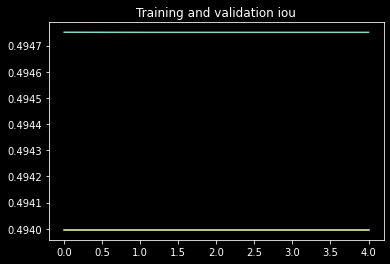

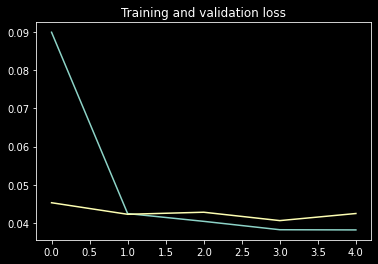

In [ ]:
iou = history.history['mean_io_u_1']
loss = history.history['loss']
val_iou = history.history['val_mean_io_u_1']
val_loss = history.history['val_loss']

epochs = range(len(iou))
plt.figure()

plt.plot(epochs,iou)
plt.plot(epochs, val_iou)
plt.title('Training and validation iou')

plt.figure()

plt.plot(epochs,loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

plt.show()

In [ ]:
!cp "/content/brain-model-3.h5" "/content/drive/MyDrive/Machine Learning/Trained Models/"

In [ ]:
X_train.shape

(3929, 256, 256, 3)

In [ ]:
X_test = X_train[0:len(X_train):20]
X_test.shape

(197, 256, 256, 3)

In [ ]:
y_hat = model.predict(X_test, verbose = 1)

7/7 [==============================] - 7s 390ms/step


In [ ]:
y_hat.shape

(197, 256, 256, 1)

(256, 256, 3)


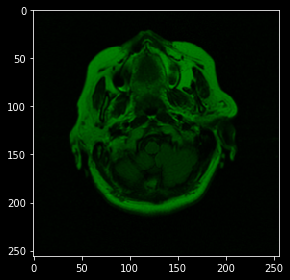

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


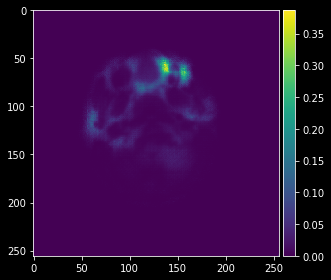

In [ ]:
id = np.random.randint(0,len(X_test)-1)
print(X_test[id].shape)
imshow(X_test[id])
plt.show()
imshow(y_hat[id][:,:,0])
plt.show()

In [ ]:
test_img = imread("/content/drive/MyDrive/Machine Learning/projects/Brain_Tumor_Segmentation/Test_images/test-2.jpg")
test_ = resize(test_img, (IMG_HEIGHT, IMG_WIDTH, 3), mode = "constant", preserve_range= True)
test_ = test_.astype(np.uint8)


In [ ]:
test_ = test_.reshape((1,IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
test_.shape

(1, 256, 256, 3)

In [ ]:
y_test = model.predict(test_)
y_test.shape

(1, 256, 256, 1)

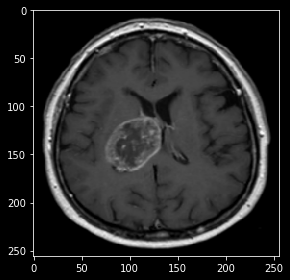

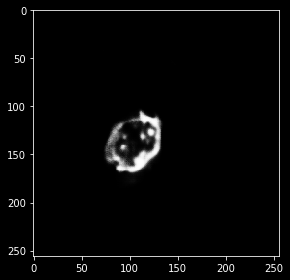

In [ ]:
imshow(test_)
plt.figure()
imshow(y_test[0][:,:,0])